In [1]:
from torch_geometric.datasets import Planetoid, MNISTSuperpixels
from torchvision.datasets import MNIST
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.data import NeighborSampler
import wandb
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import numpy as np
from utils.img_to_graph import convert_img_to_superpixels_graph
from torch_geometric.data import Data

In [2]:
print("Reading dataset")
dataset = MNIST("../data/", download=True)

Reading dataset


60000
(60000, 28, 28, 1)


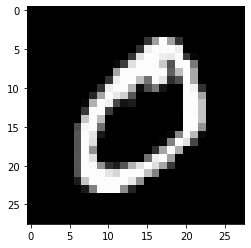

In [3]:
imgs = dataset.data.unsqueeze(-1).numpy().astype(np.float64)
print(len(imgs))
print(imgs.shape)


first_image = imgs[1]
plt.imshow(first_image, cmap='gray')
plt.show()

(256, 256, 3)


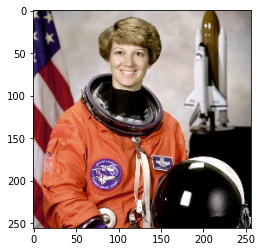

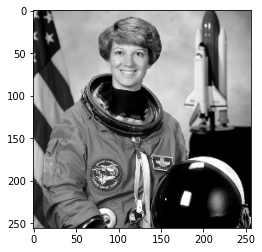

SLIC number of segments: 80


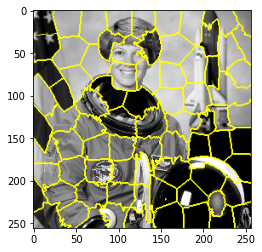

In [14]:
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
from skimage.util import img_as_float
from skimage.color import gray2rgb, rgb2gray


img = img_as_float(astronaut()[::2, ::2])
print(img.shape)
plt.imshow(img)
plt.show()

img = rgb2gray(img) 
img = gray2rgb(img)
plt.imshow(img)
plt.show()

segments = slic(img, n_segments=75, slic_zero=True, start_label=0)

print(f"SLIC number of segments: {len(np.unique(segments))}")

plt.imshow(mark_boundaries(img, segments))
plt.show()

(28, 28, 1)


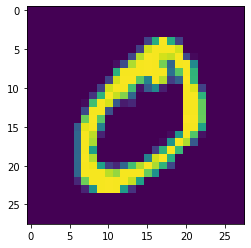

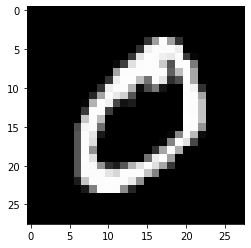

(28, 28)


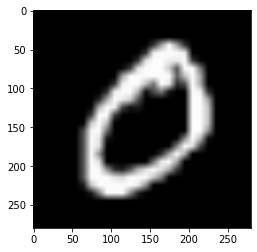

SLIC number of segments: 81
(280, 280, 3)


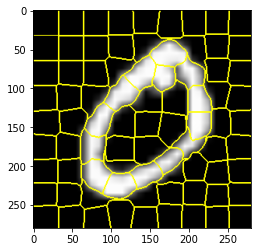

In [17]:
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
from skimage.util import img_as_float
from skimage.color import gray2rgb
from skimage.transform import rescale

plt.imshow(first_image)
print(first_image.shape)
plt.show()

img = first_image.reshape((28, 28)) / 255

img_rgb = gray2rgb(img)
plt.imshow(img_rgb)
plt.show()

print(img.shape)

img_rescaled = rescale(img, 10.0, anti_aliasing=False)
img_rescaled = gray2rgb(img_rescaled)
plt.imshow(img_rescaled)
plt.show()


segments = slic(img_rescaled, n_segments=75, slic_zero=True, start_label=0)

print(f"SLIC number of segments: {len(np.unique(segments))}")

print(img_rescaled.shape)

plt.imshow(mark_boundaries(img_rescaled, segments))
plt.show()

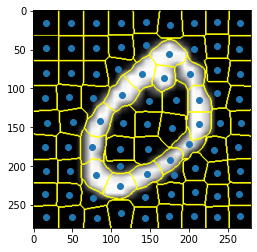

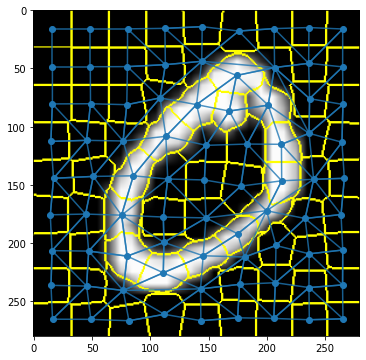

In [18]:
import matplotlib.lines as lines


# centers
segments_ids = np.unique(segments)
centers = np.array([np.mean(np.nonzero(segments==i), axis=1) for i in segments_ids])

plt.imshow(mark_boundaries(img_rescaled, segments))
plt.scatter(centers[:,1],centers[:,0])


vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plt.imshow(mark_boundaries(img_rescaled, segments))
plt.scatter(centers[:,1], centers[:,0])

for i in range(bneighbors.shape[1]):
    y0, x0 = centers[bneighbors[0,i]]
    y1, x1 = centers[bneighbors[1,i]]

    l = lines.Line2D([x0,x1], [y0,y1], alpha=0.8)
    ax.add_line(l)